# Meteorite landings on Earth

Maaike de Jong

Ironhack Amsterdam Data Analytics

Project 3, April 2020

## 1. Introduction

In this notebook I analyse and visualize the NASA Meteorite Landings dataset, which can be found [here](https://www.kaggle.com/nasa/meteorite-landings). The [Meteoritical Society](https://www.lpi.usra.edu/meteor/) collects data on meteorites that have fallen to Earth from outer space. 

#### Aim of this project
Meteorites have fascinated me for a long time. When they enter our atmosphere as shooting stars they have often travelled for millions of kilometers. Many of the meteorites that reach our planet are very old, dating from the early days of our solar system, so they are older than the rocks from Earth. My goal is to one day find a meteorite myself. This dataset offers a great opportunity to visually investigate where the chances of finding a meteorite are highest. In this notebook I take several approaches to visualising data on maps to figure out where I should go to find a meteorite.

#### About the data
This dataset includes the location, mass, composition, and fall year for over 45,000 meteorites that have struck our planet. There are a few notes on Kaggle on missing or incorrect data points in this dataset, which I'll take into account during data cleaning:
* a few entries here contain date information that was incorrectly parsed into the NASA database. As a spot check: any date that is before 860 CE or after 2016 are incorrect; these should actually be BCE years. There may be other errors and we are looking for a way to identify them.
* a few entries have latitude and longitude of 0N/0E (off the western coast of Africa, where it would be quite difficult to recover meteorites). Many of these were actually discovered in Antarctica, but exact coordinates were not given. 0N/0E locations should probably be treated as NA.

## 2. Import Packages and data

In [1]:
# import packages
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd

In [2]:
# import dataset
df = pd.read_csv('../data/meteorite-landings.csv')
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


## 3. Inspecting and cleaning the data

Before I start with visualising the data, I inspect the data to check variable properties and distributions and to find and fix mistakes or unwanted datapoints. 

In [3]:
# inspect data types
#df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
name           45716 non-null object
id             45716 non-null int64
nametype       45716 non-null object
recclass       45716 non-null object
mass           45585 non-null float64
fall           45716 non-null object
year           45428 non-null float64
reclat         38401 non-null float64
reclong        38401 non-null float64
GeoLocation    38401 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [4]:
# Check missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df
# there are some missing values for mass and year (3% and 6% respectively). 
# There are quite a few missing geolocations(16%).
#Paolo: good idea checking missing values

,column_name,percent_missing
name,name,0.000000
id,id,0.000000
nametype,nametype,0.000000
recclass,recclass,0.000000
mass,mass,0.286552
fall,fall,0.000000
year,year,0.629976
reclat,reclat,16.000962
reclong,reclong,16.000962
GeoLocation,GeoLocation,16.000962


In [5]:
# convert year from float to integer
df['year'] = df['year'].fillna(0).astype(int)
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
name           45716 non-null object
id             45716 non-null int64
nametype       45716 non-null object
recclass       45716 non-null object
mass           45585 non-null float64
fall           45716 non-null object
year           45716 non-null int64
reclat         38401 non-null float64
reclong        38401 non-null float64
GeoLocation    38401 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 3.5+ MB


In [6]:
# inspect data with describe
df.describe()

,id,mass,year,reclat,reclong
count,45716.000000,4.558500e+04,45716.000000,38401.000000,38401.000000
mean,26889.735104,1.327808e+04,1979.224495,-39.122580,61.074319
std,16860.683030,5.749889e+05,159.904386,46.378511,80.647298
min,1.000000,0.000000e+00,0.000000,-87.366670,-165.433330
25%,12688.750000,7.200000e+00,1987.000000,-76.714240,0.000000
50%,24261.500000,3.260000e+01,1998.000000,-71.500000,35.666670
75%,40656.750000,2.026000e+02,2003.000000,0.000000,157.166670
max,57458.000000,6.000000e+07,2501.000000,81.166670,354.473330


In the notes that came with the dataset it states that years before 860 and after 2016 are unreliable, and that there are several incorrect coordinates of (0,0), so those need to be filtered out.

In [7]:
# clean data
# filter out data with year < 860 and > 2016 
df2 = df.loc[(df['year'] >= 860) & (df['year'] <= 2016)]

In [8]:
# clean data
# filter out data with 0,0 coordinates
df3 = df2.loc[(df2['reclat'] != 0) & (df2['reclong'] != 0)]

In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39015 entries, 0 to 45715
Data columns (total 10 columns):
name           39015 non-null object
id             39015 non-null int64
nametype       39015 non-null object
recclass       39015 non-null object
mass           38900 non-null float64
fall           39015 non-null object
year           39015 non-null int64
reclat         31813 non-null float64
reclong        31813 non-null float64
GeoLocation    31813 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 3.3+ MB


In [10]:
# inspecting properties and distribution of variables

# types of recclass
meteor_types = pd.DataFrame(df3['recclass'].value_counts())
meteor_types.head()

# There are 441 distinct meteorite types in the data. 
# If I want to plot different types I'll have to make a selection

,recclass
L6,7244
H5,6412
L5,4216
H6,3669
H4,3625


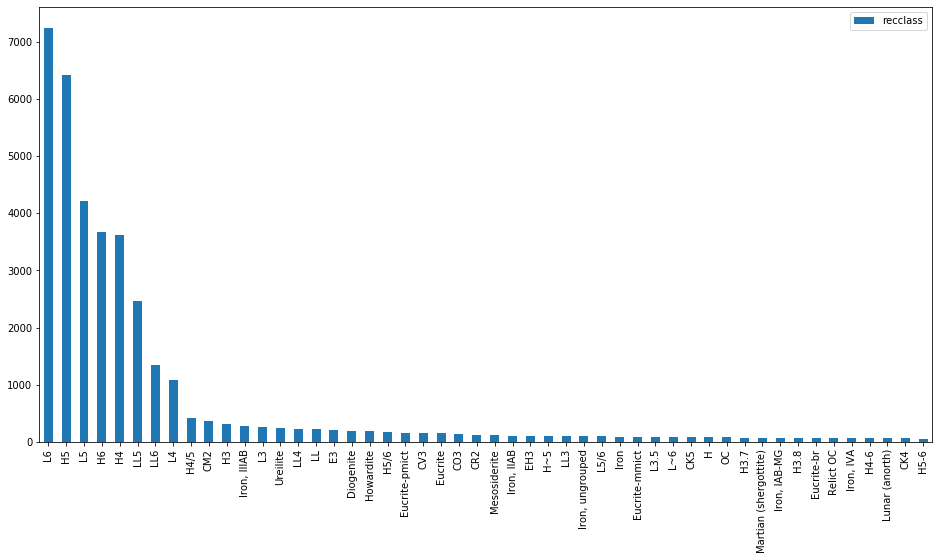

In [11]:
# Plotting the counts of the meteor types we can see that are 8 most common types, 
# after which there are many types with relatively low numbers

plt.rcParams['figure.figsize'] = [16,8]
meteor_types.head(50).plot.bar()


#### Types of meteorite

The most common types of meteorites in the data are:
L6, H5, L5, H6, H4, LL5, LL6, L4

These all fall in the category 'ordinary chondrites'

From wikipedia:
A chondrite /ˈkɒndraɪt/ is a stony (non-metallic) meteorite that has not been modified, by either melting or differentiation of the parent body. They are formed when various types of dust and small grains in the early Solar System accreted to form primitive asteroids. Some such bodies that are captured in the planet’s gravity well become the most common type of meteorite by (whether quickly, or after many orbits) arriving on a trajectory toward the Earth’s surface. Estimates for their contribution to the total meteorite population vary between 85.7% and 86.2%.

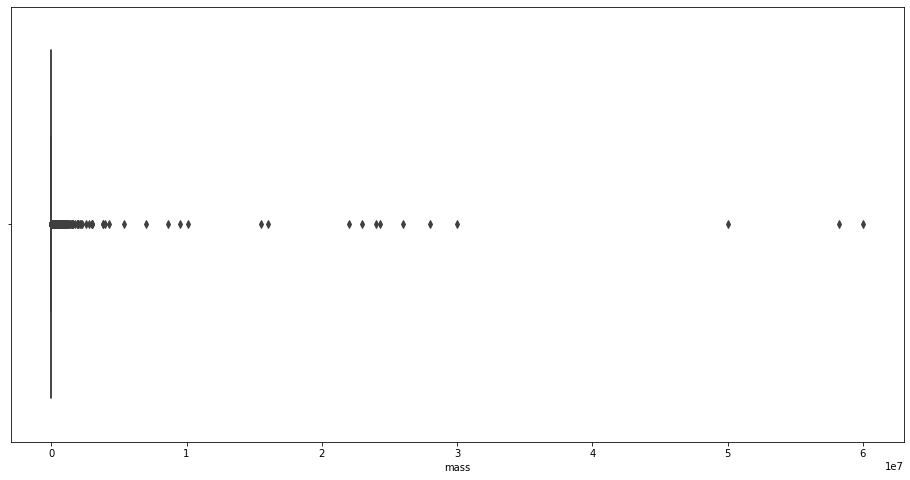

In [12]:
# inspecting properties and distribution of variables

# distribution of mass

#df3.plot.hist(y = 'mass')
sns.boxplot(x = 'mass', data = df3)

# the distribution is difficult to visualize because of outliers with a lot of mass
# if I want to do anything with mass I have to make groupings or convert the data

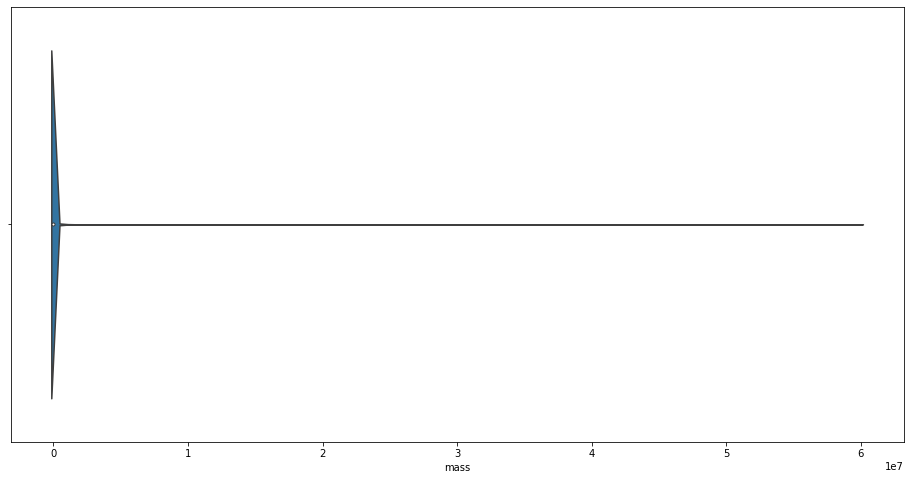

In [13]:
sns.violinplot(x = 'mass', data = df3)

In [14]:
# inspecting properties and distribution of variables

# column 'fall'

df3['fall'].value_counts()

# There are many more 'found' meteorites than 'fell' meteorites

Found    37910
Fell      1105
Name: fall, dtype: int64

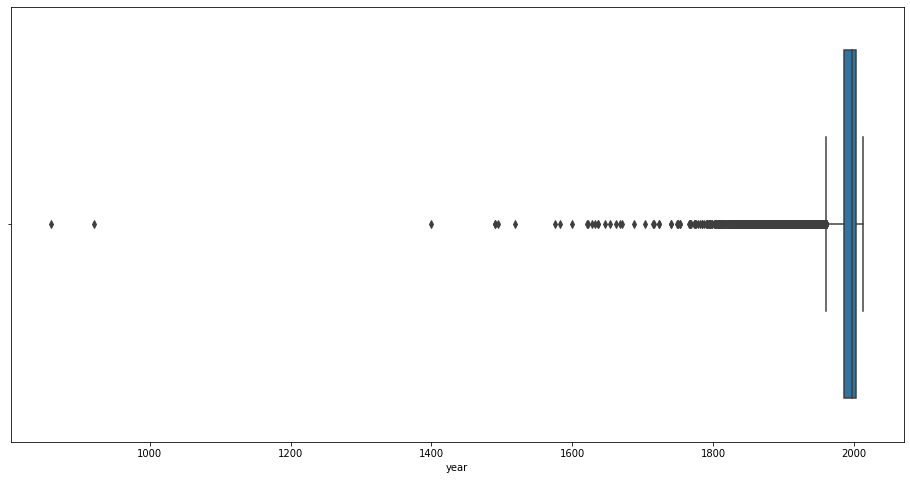

In [15]:
# inspecting properties and distribution of variables

# column 'year'

sns.boxplot(x = 'year', data = df3)

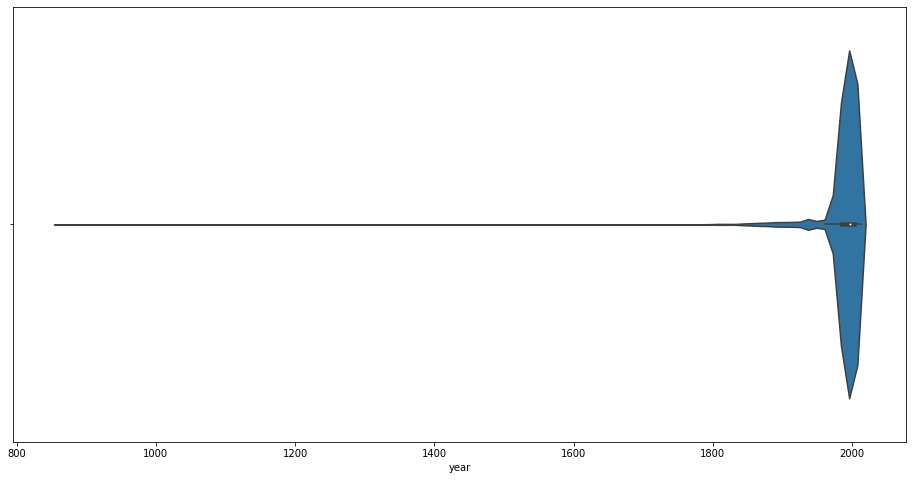

In [16]:
sns.violinplot(x = 'year', data = df3)

# the vast majority of observations are between 1900 and 2016, which is to be expected

## 4. Plotting the meteorites on a world map

There are many ways to visualise the meteorite data on maps, but as a start I'll plot all the meteorites as points on a world map.

To do this, there are two main steps:
* convert the data into geospatial data so it can be spatially plotted with a package such as geopandas
* get data to plot a world map
* plot the world map data and the meteorite data in two layers

In [17]:
# create geodataframe, with geometry column from long, lat columns

gdf = gpd.GeoDataFrame(df3, geometry = gpd.points_from_xy(df3['reclong'], df3['reclat']))
gdf.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,geometry
0,Aachen,1,Valid,L5,21.0,Fell,1880,50.77500,6.08333,"(50.775000, 6.083330)",POINT (6.08333 50.77500)
1,Aarhus,2,Valid,H6,720.0,Fell,1951,56.18333,10.23333,"(56.183330, 10.233330)",POINT (10.23333 56.18333)
2,Abee,6,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,"(54.216670, -113.000000)",POINT (-113.00000 54.21667)
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,"(16.883330, -99.900000)",POINT (-99.90000 16.88333)
4,Achiras,370,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,"(-33.166670, -64.950000)",POINT (-64.95000 -33.16667)


In [18]:
#check whether the geometry column is the right datatype. It should be a geopandas geoseries

type(gdf.geometry)

geopandas.geoseries.GeoSeries

In [19]:
# import world map geodataframe. The lowres worldmap dataset from Natural Earth can be imported directly from geopandas

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.rename(columns = {'name': 'country'}, inplace = True)
world.head()

,pop_est,continent,country,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


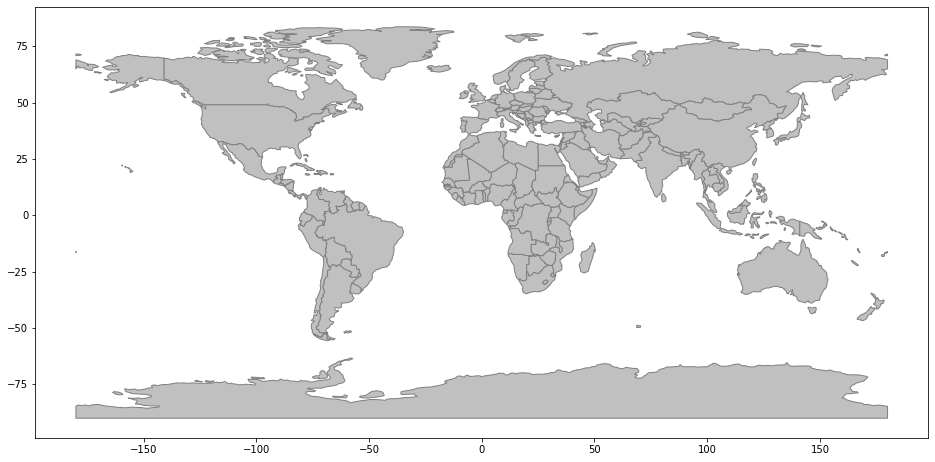

In [20]:
# plot world map with country borders

plt.rcParams['figure.figsize'] = [16,8]
world.plot(facecolor = 'silver', edgecolor = 'grey');

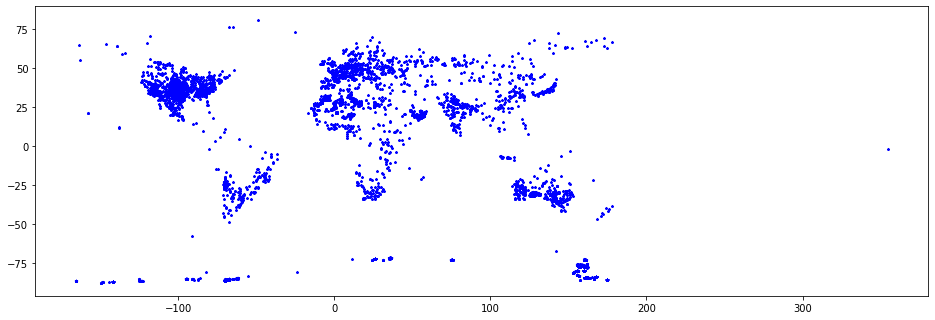

In [21]:
# Plot layer of meteorites

gdf.plot(marker='*', color='blue', markersize=5);

In [22]:
# There's a weird point that must be a mistake. longitude is larger than 300
# find entry in df 

gdf.loc[(df3['reclong'] > 300)]

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,geometry
22946,Meridiani Planum,32789,Valid,"Iron, IAB complex",NaN,Found,2005,-1.94617,354.47333,"(-1.946170, 354.473330)",POINT (354.473 -1.946)


In [23]:
# remove entry

gdf = gdf.drop([22946], axis=0)

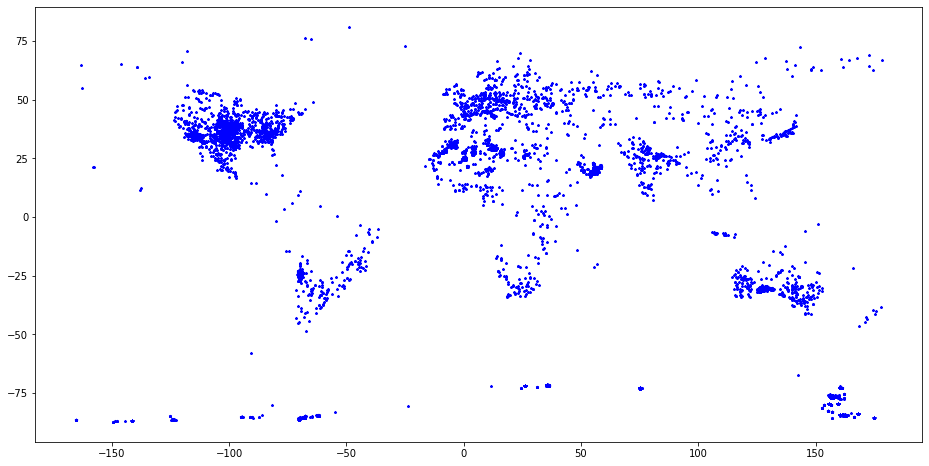

In [24]:
# Plot meteorites again to check whether the point is gone

gdf.plot(marker='*', color='blue', markersize=5);
#Paolo: great idea to use geopandas and visualize the data on a world map

In [25]:
# Before combining maps, ensure they share a common CRS (coordinate system) so that they will spatially align

# first assign a CRS to the gdf (a common one is WGS84 latitude-longitude coordinate system)

gdf.crs = "EPSG:4326"

# then, align crs to world crs

gdf = gdf.to_crs(world.crs)
#Paolo: this cell gives error

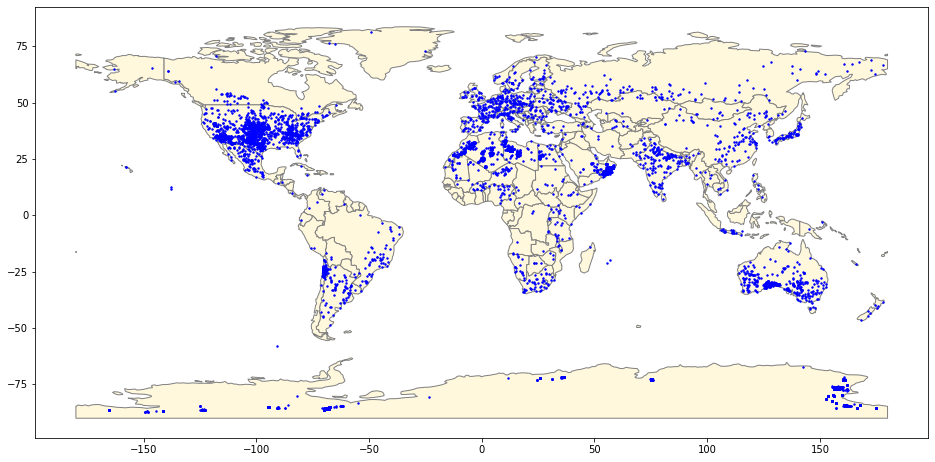

In [26]:
# Plotting the world map data and the meteorite points in two layers:

base = world.plot(color='cornsilk', edgecolor='grey')
gdf.plot(ax=base, marker='o', color='blue', markersize=2);

#### Insights from this map
From this map it looks like by far the most meteorites were found in the US. That might be because the Meteoritical Society is based in the US. 
What also stands out to me is that the densities are lowest in the most forested areas: Amazon basin, Congo basin, and South-East Asia and the boreal forests of Canada and Northern Russia. This makes sense because finding meteorites in forested areas must be more difficult than open areas, and also soil turnover is high in forests. 

Although this figure gives a nice overview of overall densities, there is also a lot of overlap between data points (because there are so many). As a next step I'll visualise the number of meteorites per country. 

## 5. Creating a choropleth map of meteorite numbers by country

To get a more detailed insight into the spatial distribution of found meteorites, I will create a so-called choropleth map of numbers of meteorites per country. 

Definition of a choropleth map (from Wikipedia):  
*A choropleth map is a type of thematic map in which areas are shaded or patterned in proportion to a statistical variable that represents an aggregate summary of a geographic characteristic within each area, such as population density or per-capita income.*

There are several steps involved in creating this map:  

**1. Create a dataframe with the total number of meteorites per country.**  
For this we first need to assign country names to the meteorite data. The dataset as it comes doesn't have country information. So based on the long, lat coordinates of the meteorites we have to group the data points corresponding to the country polygon shapes in the worldmap dataset. We can do this in geopandas with a spatial join.  

**2. Create a new dataframe combining the worldmap data and the meteorite counts per country.**  
Doing this we'll end up with a lot of missing data for the counts per country. We can fill these in with zeroes because for these countries zero meteorites were found.  

**3. Create the choropleth map in geopandas.**  
This will require some tweaking of the colour-representation of the meteorite counts as this data is highly skewed as we will see.  


In [27]:
# Create df total meteorites per country
# first, spatial join meteorite gdf and world gdf to assign countries to meteorite coordinates

gdf_countries = gpd.sjoin(world, gdf, how="right", op="contains")
gdf_countries.head()

,index_left,pop_est,continent,country,iso_a3,gdp_md_est,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,geometry
861,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Rupota,22783,Valid,L4-6,6000.0,Fell,1949,-10.26667,38.76667,"(-10.266670, 38.766670)",POINT (38.76667 -10.26667)
778,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Peramiho,18792,Valid,Eucrite-mmict,165.0,Fell,1899,-10.66667,35.50000,"(-10.666670, 35.500000)",POINT (35.50000 -10.66667)
22921,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Mbosi,15456,Valid,"Iron, ungrouped",16000000.0,Found,1930,-9.11667,33.06667,"(-9.116670, 33.066670)",POINT (33.06667 -9.11667)
402,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Ishinga,12049,Valid,H,1300.0,Fell,1954,-8.93333,33.80000,"(-8.933330, 33.800000)",POINT (33.80000 -8.93333)
406,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Ivuna,12063,Valid,CI1,704.5,Fell,1938,-8.41667,32.43333,"(-8.416670, 32.433330)",POINT (32.43333 -8.41667)


In [28]:
# rename country column
gdf_countries.rename(columns = {'name_x': 'country'}, inplace = True)
gdf_countries.head()

,index_left,pop_est,continent,country,iso_a3,gdp_md_est,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,geometry
861,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Rupota,22783,Valid,L4-6,6000.0,Fell,1949,-10.26667,38.76667,"(-10.266670, 38.766670)",POINT (38.76667 -10.26667)
778,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Peramiho,18792,Valid,Eucrite-mmict,165.0,Fell,1899,-10.66667,35.50000,"(-10.666670, 35.500000)",POINT (35.50000 -10.66667)
22921,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Mbosi,15456,Valid,"Iron, ungrouped",16000000.0,Found,1930,-9.11667,33.06667,"(-9.116670, 33.066670)",POINT (33.06667 -9.11667)
402,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Ishinga,12049,Valid,H,1300.0,Fell,1954,-8.93333,33.80000,"(-8.933330, 33.800000)",POINT (33.80000 -8.93333)
406,1.0,53950935.0,Africa,Tanzania,TZA,150600.0,Ivuna,12063,Valid,CI1,704.5,Fell,1938,-8.41667,32.43333,"(-8.416670, 32.433330)",POINT (32.43333 -8.41667)


In [29]:
# check shape

gdf_countries.shape

(39014, 17)

In [30]:
# aggregate total number of meteorites per country

by_country = gdf_countries.groupby('country')[['id']].count()
by_country = by_country.reset_index()
by_country.rename(columns = {'id': 'meteorite_count'}, inplace = True)              
by_country

,country,meteorite_count
0,Afghanistan,1
1,Algeria,625
2,Angola,4
3,Antarctica,22099
4,Argentina,67
5,Armenia,2
6,Australia,635
7,Austria,7
8,Azerbaijan,2
9,Bangladesh,7


In [31]:
# make new df with all country data, even if no meteorite data is available (otherwise there will be gaps in the worldmap)

countries_count = pd.merge(world, by_country, on = 'country', how = 'left')
countries_count.head()

,pop_est,continent,country,iso_a3,gdp_md_est,geometry,meteorite_count
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",9.0
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",6.0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",60.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1653.0


In [32]:
# Fill NaN values for meteorite count with zeroes

countries_count.fillna(value = 0, inplace = True)
countries_count.head()
#Paolo: weird error related to fillna values

,pop_est,continent,country,iso_a3,gdp_md_est,geometry,meteorite_count
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.0
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",9.0
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",6.0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",60.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1653.0


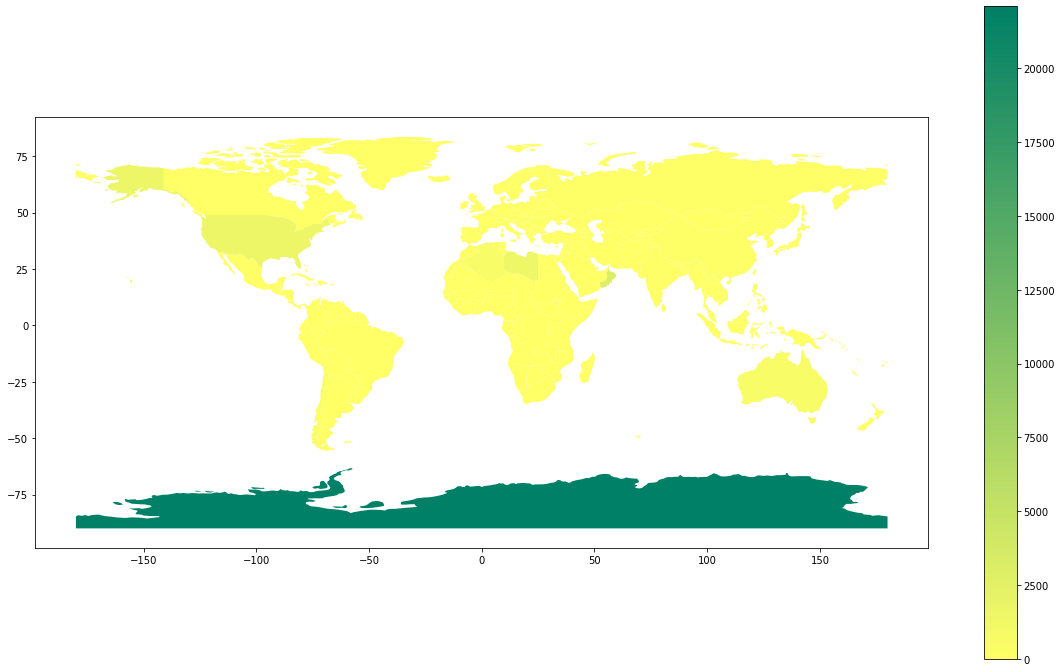

In [33]:
# make choropleth map with number of meteorites per country indicated with colours
# see: https://geopandas.org/mapping.html
# include legend

plt.rcParams['figure.figsize'] = [20,12]
fig, ax = plt.subplots(1, 1)
countries_count.plot(column='meteorite_count', ax=ax, legend=True, cmap='summer_r') #legend_kwds={'label': "Found meteorites by country",'orientation': "horizontal"})


#### Insights from this map

This map shows very clearly that by far the most meteorites have been found in Antarctica. In comparison the numbers for the other countries are much lower, which makes the colour contrasts for the rest of the countries very small. 

According to our data 22099 meteorites were found in Antarctica, more or less half of our dataset. This is because several expeditions specifically dedicated to finding meteorites were organised in recent years. Meteorites are relatively easy to find in Antarctica because they fall on the ice sheet and are very visible.  

To create more contrast between the countries, we can tweak the colour scaling with the scheme option.  


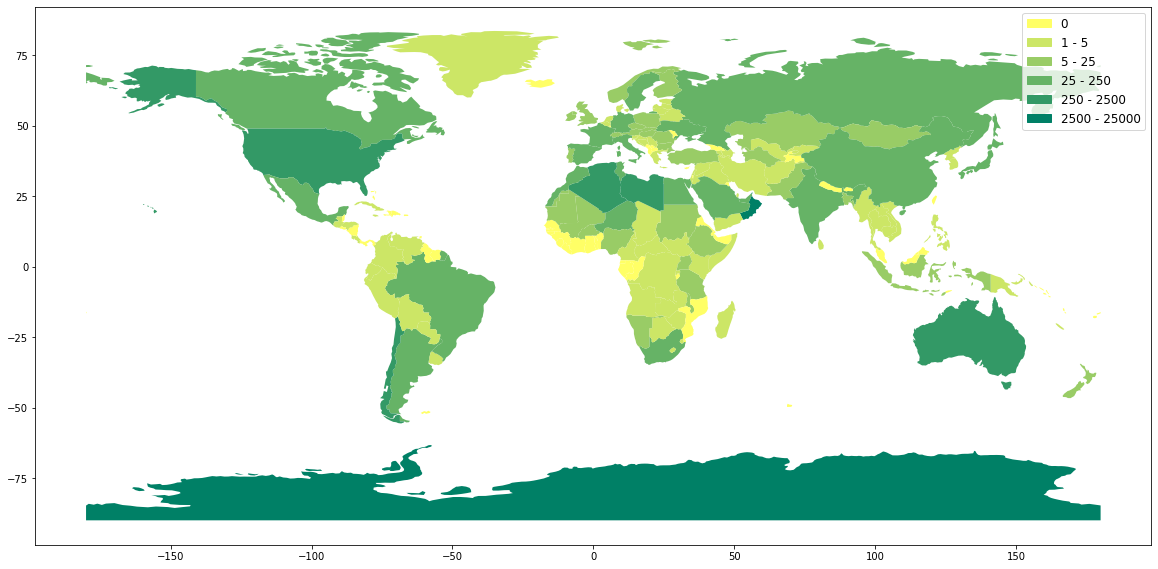

In [35]:
# plot choropleth map with scheme option with user defined settings

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1, 1)

countries_count.plot(column='meteorite_count', legend=True, ax = ax, cmap='summer_r', scheme='user_defined', classification_kwds = {'bins':[0, 5, 25, 250, 2500, 25000]})

cmap = cm.get_cmap('summer_r')
patch1 = mpatches.Patch(color=cmap(0.0), label = '0')
patch2 = mpatches.Patch(color=cmap(0.2), label = '1 - 5')
patch3 = mpatches.Patch(color=cmap(0.4), label = '5 - 25')
patch4 = mpatches.Patch(color=cmap(0.6), label = '25 - 250')
patch5 = mpatches.Patch(color=cmap(0.8), label = '250 - 2500')
patch6 = mpatches.Patch(color=cmap(1.0), label = '2500 - 25000')

plt.legend(handles = [patch1, patch2, patch3, patch4, patch5, patch6], prop = {'size':12})

plt.show()


#### Insights from this map

Apart from Antarctica, other countries where a lot of meteorites were found are: the US, Australia, Chile, Morocco, Algeria, Libia and Oman.  

These patterns are most likely explained by two main factors: national interest in meteorites (US, where the Meteoritical Society is based), and landscape/ ecotype. Apart from the US and Antartica, the other counties mentioned above all largely consist of desert, where meteorites are easier to find.   

Let's now have a look at the map without Antarctica.

In [36]:
# create new dataframe without Antarctica data

countries_count2 = countries_count[countries_count['continent'] != 'Antarctica']

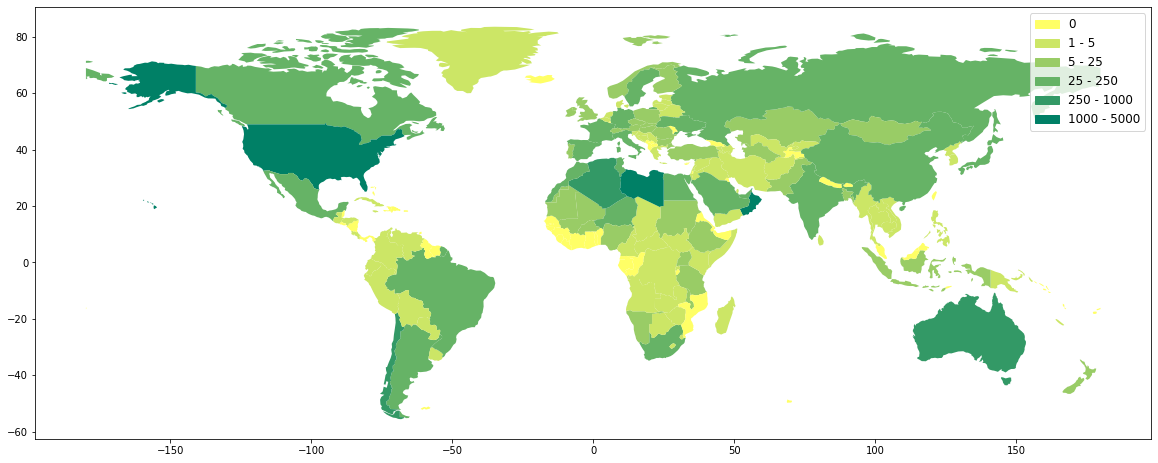

In [37]:
# plot the map

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1, 1)

countries_count2.plot(column='meteorite_count', legend=True, ax = ax, cmap='summer_r', scheme='user_defined', classification_kwds = {'bins':[0, 5, 25, 250, 1000, 5000]})

cmap = cm.get_cmap('summer_r')
patch1 = mpatches.Patch(color=cmap(0.0), label = '0')
patch2 = mpatches.Patch(color=cmap(0.2), label = '1 - 5')
patch3 = mpatches.Patch(color=cmap(0.4), label = '5 - 25')
patch4 = mpatches.Patch(color=cmap(0.6), label = '25 - 250')
patch5 = mpatches.Patch(color=cmap(0.8), label = '250 - 1000')
patch6 = mpatches.Patch(color=cmap(1.0), label = '1000 - 5000')

plt.legend(handles = [patch1, patch2, patch3, patch4, patch5, patch6], prop = {'size':12})

plt.show()


#### Insights from this map

Removing Antarctica gives a more precise view of the differences between countries. According to this map the most meteorites were found in the US, Libya and Oman. Other countries that score high are Australia, Algeria and Chile.  

When looking at possible countries to travel to for a meteorite searching expedition, Algeria looks like a suitable option. It's relatively nearby (in contrast to Australia, US and Chile) and it's relatively safe for a solo female traveller (in contrast to Libya). Oman is also supposed to be safe but one of the first google hits I got when searching for meteorites and Oman was [this](https://www.newscientist.com/article/mg21128190-200-meteorite-hunter-my-two-months-in-an-omani-jail/), so perhaps not my first choice of country.  

Let's zoom in on Algeria.



## 6. Zooming in on one country: Algeria

To investigate the meteorite situation in Algeria, we can plot the meteorite points on the map of Algeria. To do this, we need to plot the country polygon shape data as a base map and overlay the meteorite points. We'll start by importing a higher resolution worldmap using this [data folder](https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/50m_cultural.zip) that I obtained from [Natural Earth Data](https://www.naturalearthdata.com/) and selecting the Algerian shape data. After that we can select the data for Algeria from the gdf_countries geodataframe that we created in an earlier step.

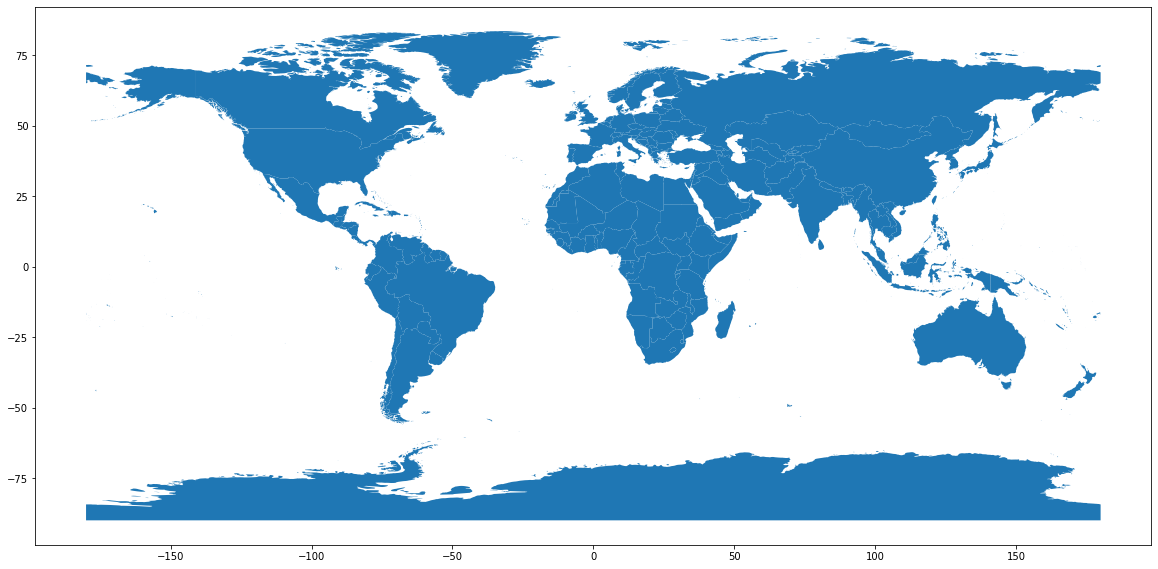

In [41]:
# import more high-res worldmap data

world2 = gpd.read_file('..data/50m_cultural/ne_50m_admin_0_countries.shp')
world2.plot()
#Paolo: this file is unknown and not clear how to download. As result the most of the cells below do not run

In [42]:
# inspect worlddata gdf

world2.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,짐바브웨,Zimbabwe,Zimbabwe,Zimbábue,Зимбабве,Zimbabwe,Zimbabve,Zimbabwe,辛巴威,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,잠비아,Zambia,Zambia,Zâmbia,Замбия,Zambia,Zambiya,Zambia,赞比亚,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,예멘,Jemen,Jemen,Iémen,Йемен,Jemen,Yemen,Yemen,也门,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,Vietnam,VNM,...,베트남,Vietnam,Wietnam,Vietname,Вьетнам,Vietnam,Vietnam,Việt Nam,越南,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,Venezuela,VEN,...,베네수엘라,Venezuela,Wenezuela,Venezuela,Венесуэла,Venezuela,Venezuela,Venezuela,委內瑞拉,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


In [43]:
# select map shape Algeria

algeria = world2.loc[world2['SOVEREIGNT'] == 'Algeria']
algeria

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
235,Admin-0 country,1,3,Algeria,DZA,0,2,Sovereign country,Algeria,DZA,...,알제리,Algerije,Algieria,Argélia,Алжир,Algeriet,Cezayir,Algérie,阿尔及利亚,"POLYGON ((8.57656 36.93721, 8.59766 36.88389, ..."


In [44]:
# select meteorite data for algeria

algeria_count = gdf_countries.loc[gdf_countries['country'] == 'Algeria']
algeria_count.head()

,index_left,pop_est,continent,country,iso_a3,gdp_md_est,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,geometry
16317,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Haniet-el-Beguel,11817,Valid,"Iron, IAB complex",2000.0,Found,1888,32.483330,4.400000,"(32.483330, 4.400000)",POINT (4.40000 32.48333)
274,82.0,40969443.0,Africa,Algeria,DZA,609400.0,El Idrissia,7807,Valid,L6,10000.0,Fell,1989,34.416670,3.250000,"(34.416670, 3.250000)",POINT (3.25000 34.41667)
57,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Aumale,4899,Valid,L6,50000.0,Fell,1865,36.166670,3.666670,"(36.166670, 3.666670)",POINT (3.66667 36.16667)
968,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Tadjera,23778,Valid,L5,9000.0,Fell,1867,36.183330,5.416670,"(36.183330, 5.416670)",POINT (5.41667 36.18333)
11622,82.0,40969443.0,Africa,Algeria,DZA,609400.0,El-Oued,47729,Valid,H4,2305.0,Found,1952,31.533333,8.883333,"(31.533333, 8.883333)",POINT (8.88333 31.53333)


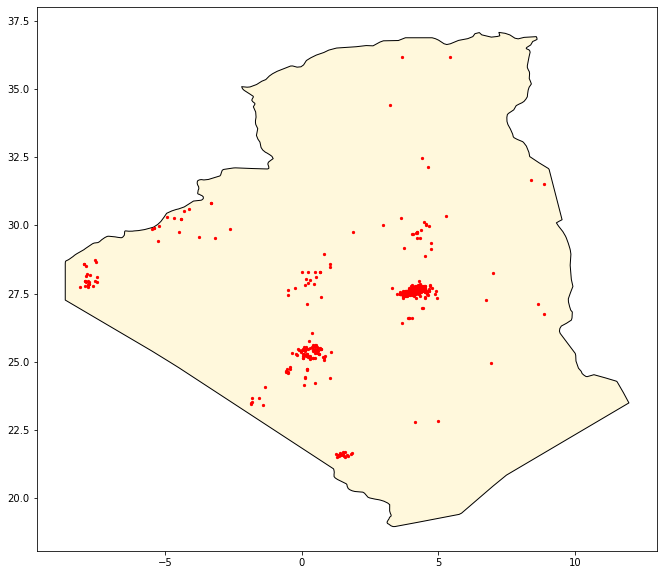

In [45]:
# plot two layer map for Algeria

base = algeria.plot(color='cornsilk', edgecolor='black')
algeria_count.plot(ax=base, marker='o', color='red', markersize=5);

#### Insights from this map

This map shows that there are several clear clusters of meterorite finds. They could be cause by expeditions, or perhaps by larger meteorite impacts.  

Let's look at meteorite types in more detail.  


In [46]:
# counting the top 10 meteorite types in the Algeria data

algeria_top10 = pd.DataFrame(algeria_count['recclass'].value_counts().head(10))
algeria_top10 = algeria_top10.reset_index()
algeria_top10

,index,recclass
0,H5,127
1,L6,111
2,H6,55
3,L5,45
4,H4,36
5,LL6,20
6,CR2,20
7,H4/5,14
8,L4,13
9,LL5-6,12


Interestingly, there is a generally rare type of meteorite on the 7th spot: CR2. In the main data this type is ranked 25th in frequency.  

This is the Carbonaceous Chondrite Type, a rare and much sought-after type of meteorite.  

Let's look at the distribution of the top 10 meteorites in Algeria.  


In [47]:
# Select meteorite data for algeria, top 10 most common meteorites

algeria_count10 = algeria_count.loc[algeria_count['recclass'].isin(algeria_top10['index'])]
algeria_count10.head()

,index_left,pop_est,continent,country,iso_a3,gdp_md_est,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,geometry
274,82.0,40969443.0,Africa,Algeria,DZA,609400.0,El Idrissia,7807,Valid,L6,10000.0,Fell,1989,34.416670,3.250000,"(34.416670, 3.250000)",POINT (3.25000 34.41667)
57,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Aumale,4899,Valid,L6,50000.0,Fell,1865,36.166670,3.666670,"(36.166670, 3.666670)",POINT (3.66667 36.16667)
968,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Tadjera,23778,Valid,L5,9000.0,Fell,1867,36.183330,5.416670,"(36.183330, 5.416670)",POINT (5.41667 36.18333)
11622,82.0,40969443.0,Africa,Algeria,DZA,609400.0,El-Oued,47729,Valid,H4,2305.0,Found,1952,31.533333,8.883333,"(31.533333, 8.883333)",POINT (8.88333 31.53333)
5076,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Bir Rebaa,5054,Valid,H6,7200.0,Found,1993,31.666670,8.416670,"(31.666670, 8.416670)",POINT (8.41667 31.66667)


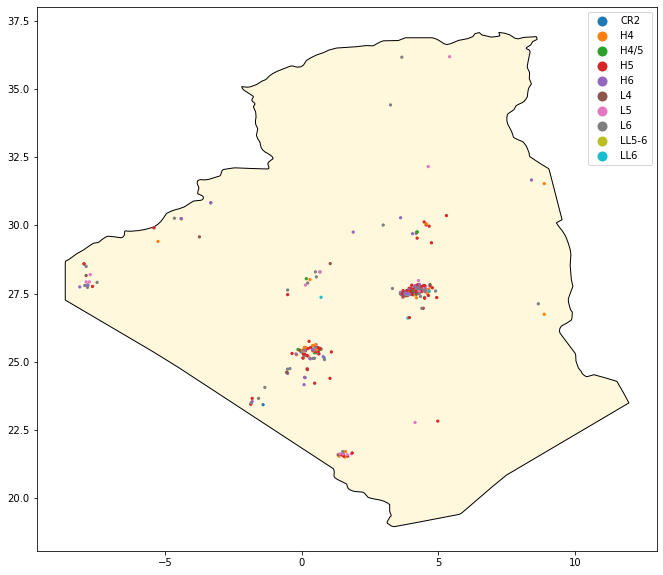

In [48]:
# plot them on the map, colourcoded

base = algeria.plot(color='cornsilk', edgecolor='black')
algeria_count10.plot(ax=base, marker='o', column='recclass', legend = True, markersize=5);
#Paolo: error, algeria not defined

In [49]:
# there are a lot of points in the same spot, making it difficult to see where the CR2 type is
# to visualize the rare meteorite type better, we select and plot only this type

algeria_CR2 = algeria_count.loc[algeria_count['recclass'] == 'CR2']
algeria_CR2.head()

,index_left,pop_est,continent,country,iso_a3,gdp_md_est,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,geometry
1198,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Acfer 087,96,Valid,CR2,163.0,Found,1990,27.70000,4.26667,"(27.700000, 4.266670)",POINT (4.26667 27.70000)
1225,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Acfer 114,123,Valid,CR2,43.0,Found,1990,27.60000,3.96667,"(27.600000, 3.966670)",POINT (3.96667 27.60000)
1250,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Acfer 139,148,Valid,CR2,143.0,Found,1990,27.56667,4.08333,"(27.566670, 4.083330)",POINT (4.08333 27.56667)
1506,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Acfer 400,55264,Valid,CR2,101.0,Found,2001,27.50083,3.86617,"(27.500830, 3.866170)",POINT (3.86617 27.50083)
1433,82.0,40969443.0,Africa,Algeria,DZA,609400.0,Acfer 324,30428,Valid,CR2,69.0,Found,2001,27.50083,3.86983,"(27.500830, 3.869830)",POINT (3.86983 27.50083)


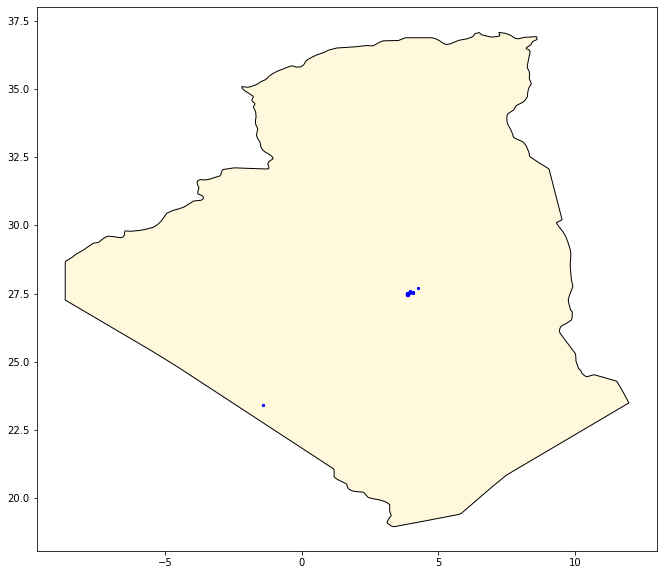

In [50]:
# plot CR2 on map

base = algeria.plot(color='cornsilk', edgecolor='black')
algeria_CR2.plot(ax=base, marker='o', color = 'blue', markersize=5)


#### Insights from this maps

The CR2 meteorites are nearly all in the same spot (except one). Perhaps a bigger meteorite of this type fell and these are all pieces of it.  

Looking at the meteorite data, these meteorites are all from location 'Acfer'. After some googling, it turns out that there was a recent discovery in a meteorite from this place, which seems to show that there are extra-terrestrial proteins present in the meteorite. See this scientific [publication](https://arxiv.org/abs/2002.11688) (currently under peer-review).  

This is definitely an interesting meteorite hotspot to explore!


## 7. Conclusions and next steps

This visual analysis gave me a clear overview of the numbers of found meteorites per country, and which countries are promising locations for a meteorite-hunting expedition. For Algeria it appears that there is a particularly interesting spot, where a relatively high number of rarer meteorites were found. 

A few possible next steps for this analysis are:
1. Creating maps with geographical features. For instance, this would give me a better idea of the exact area and landscape of the Algeria hotspot. 
2. Have a closer look into the distribution of meteorite types, like I now did for Algeria but at global level or for other countries.
3. Create interactive maps (e.g. with Bokeh) and maps that can be integrated into websites (Plotly).  

